In [29]:
import os
import pandas as pd
import numpy as np
import re

#Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 7.0)
import seaborn as sns
from matplotlib.patches import Circle, Rectangle, Arc
from matplotlib import animation, rc
from IPython.display import HTML
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
pd.options.mode.chained_assignment = None

from shapely.geometry import LineString

In [88]:
os.chdir("F:/CSV DATA")
shots=pd.read_csv("F:/ProjectTimDuncan/playershotsdf.csv")
game=shots[shots["GAME_ID"]==21500592]

In [89]:
motion=pd.read_csv("0021500592.csv",low_memory=False)
motion=motion[motion.isnull().any(axis=1)==False].reset_index(drop=True)

In [4]:
def draw_court(ax=None, color="gray", lw=1, zorder=0):
    
    if ax is None:
        ax = plt.gca()

    # Creates the out of bounds lines around the court
    outer = Rectangle((0,-50), width=94, height=50, color=color,
                      zorder=zorder, fill=False, lw=lw)

    # The left and right basketball hoops
    l_hoop = Circle((5.35,-25), radius=.75, lw=lw, fill=False, 
                    color=color, zorder=zorder)
    r_hoop = Circle((88.65,-25), radius=.75, lw=lw, fill=False,
                    color=color, zorder=zorder)
    
    # Left and right backboards
    l_backboard = Rectangle((4,-28), 0, 6, lw=lw, color=color,
                            zorder=zorder)
    r_backboard = Rectangle((90, -28), 0, 6, lw=lw,color=color,
                            zorder=zorder)

    # Left and right paint areas
    l_outer_box = Rectangle((0, -33), 19, 16, lw=lw, fill=False,
                            color=color, zorder=zorder)    
    l_inner_box = Rectangle((0, -31), 19, 12, lw=lw, fill=False,
                            color=color, zorder=zorder)
    r_outer_box = Rectangle((75, -33), 19, 16, lw=lw, fill=False,
                            color=color, zorder=zorder)

    r_inner_box = Rectangle((75, -31), 19, 12, lw=lw, fill=False,
                            color=color, zorder=zorder)

    # Left and right free throw circles
    l_free_throw = Circle((19,-25), radius=6, lw=lw, fill=False,
                          color=color, zorder=zorder)
    r_free_throw = Circle((75, -25), radius=6, lw=lw, fill=False,
                          color=color, zorder=zorder)

    # Left and right corner 3-PT lines
    # a represents the top lines
    # b represents the bottom lines
    l_corner_a = Rectangle((0,-3), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    l_corner_b = Rectangle((0,-47), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    r_corner_a = Rectangle((80, -3), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    r_corner_b = Rectangle((80, -47), 14, 0, lw=lw, color=color,
                           zorder=zorder)
    
    # Left and right 3-PT line arcs
    l_arc = Arc((5,-25), 47.5, 47.5, theta1=292, theta2=68, lw=lw,
                color=color, zorder=zorder)
    r_arc = Arc((89, -25), 47.5, 47.5, theta1=112, theta2=248, lw=lw,
                color=color, zorder=zorder)

    # half_court
    # ax.axvline(470)
    half_court = Rectangle((47,-50), 0, 50, lw=lw, color=color,
                           zorder=zorder)

    hc_big_circle = Circle((47, -25), radius=6, lw=lw, fill=False,
                           color=color, zorder=zorder)
    hc_sm_circle = Circle((47, -25), radius=2, lw=lw, fill=False,
                          color=color, zorder=zorder)

    court_elements = [l_hoop, l_backboard, l_outer_box, outer,
                      l_inner_box, l_free_throw, l_corner_a,
                      l_corner_b, l_arc, r_hoop, r_backboard, 
                      r_outer_box, r_inner_box, r_free_throw,
                      r_corner_a, r_corner_b, r_arc, half_court,
                      hc_big_circle, hc_sm_circle]

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [273]:
player_matrix=motion.iloc[:,7::3]

In [5]:
def makeXY(motion):
    x_vals=motion.iloc[:,8::3]
    y_vals=motion.iloc[:,9::3]
    xy_vals=pd.concat([x_vals,y_vals],axis=1)
    xy_full=motion[["ball_x","ball_y"]+np.hstack([np.array(["player"+str(i)+"_x","player"+str(i)+"_y"]) for i in range(1,11)]).tolist()]
    xy_list=[xy.reshape(11,2) for xy in xy_full.values]
    gradients=np.hstack([np.gradient(xy_full.iloc[:,i:(i+2)].values)[0] for i in np.linspace(0,20,11,dtype="int")])
    gradients=pd.DataFrame(gradients,columns=xy_full.columns)
    grad_list=[grad.reshape(11,2) for grad in gradients.values]
    return(xy_list,grad_list)

In [80]:
xy_list,grad_list=makeXY(motion)

In [820]:
def animate(i):
    data=xy_list[i]
    player_X=data[1:,0]
    player_Y=-data[1:,1]
    ball_X=data[0,0]
    ball_Y=-data[0,1]
    for j in range(10):
        player_circ[j].center = tuple(np.hstack((player_X[j],player_Y[j]))) #change each players xy position
    ball_circ.center = tuple(np.hstack((ball_X,ball_Y))) #change ball xy position
    ball_circ.radius = 0.5+0.1*motion.iloc[i,6]
    game_description=cp.PLAYER_NAME[i]+"   Shot clock: "+motion.iloc[i,3][:2]
    ball_text.set_text(game_description)
    return(tuple(player_circ) + (ball_circ,))

def init(): #this is what matplotlib's animation will create before drawing the first frame. 
    for i in range(10): #set up players
        ax.add_patch(player_circ[i])
    ax.add_patch(ball_circ) #create ball
    ax.axis('off') #turn off axis
    plt.xlim([0,101]) #set axis
    plt.ylim([-50,0])
    return(tuple(player_circ) + (ball_circ,))

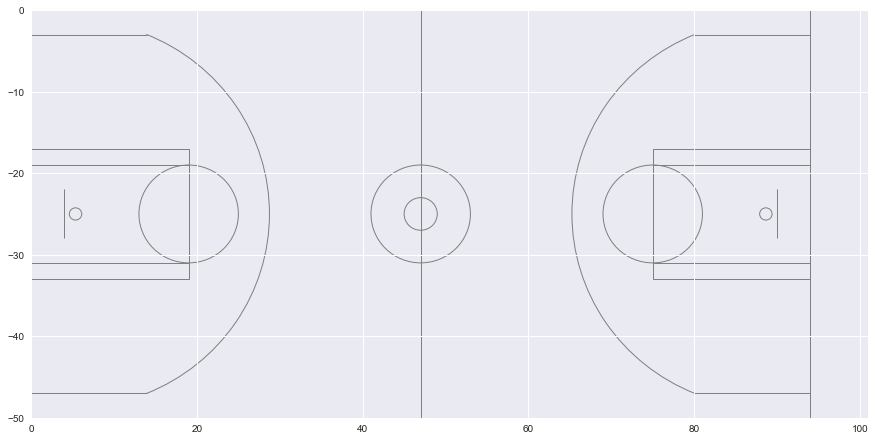

In [8]:
fig = plt.figure(figsize=(15,7.5))
ax = plt.gca()

draw_court()
ax.set_xlim(( 0, 101))
ax.set_ylim((-50, 0))
player_circ=list(range(10))
ball_circ=plt.Circle((0,0), 1.1, color=[1, 0.4, 0])

ball_text=plt.text(40, 1, '', fontsize=15)

for i in range(10): #create circle object and text object for each player
    if i < 5:
        player_circ[i] = plt.Circle((0,0), 1.2, facecolor="blue",edgecolor='k')
    else:
        player_circ[i] = plt.Circle((0,0), 1.2, facecolor="purple",edgecolor='k')

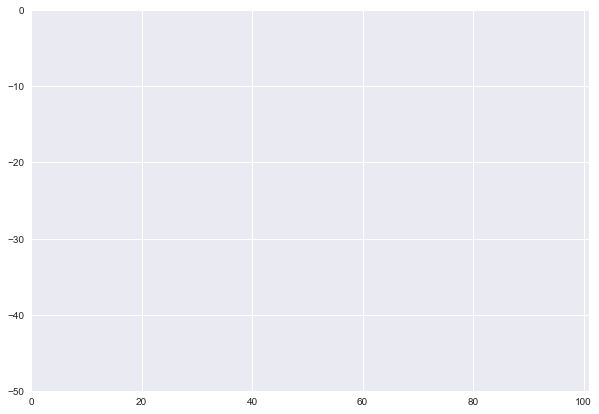

In [821]:
ani = animation.FuncAnimation(fig, animate, frames=range(7935,8184), init_func=init, blit=True, interval=60, repeat=True,save_count=0) 

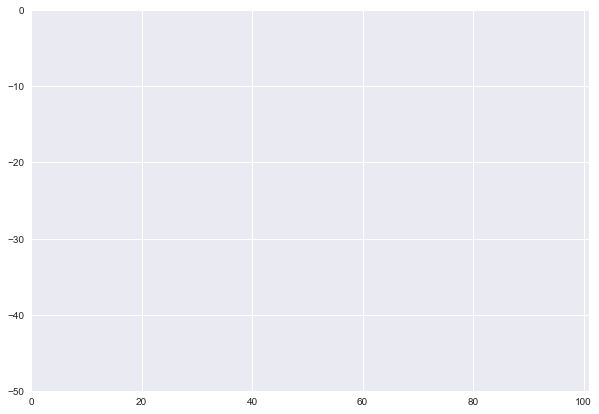

In [822]:
HTML(ani.to_html5_video())

In [1106]:
def findIndices(a,b,qtr):
    event_index=motion[(motion["sec_in_quarter"]<=a)&(motion["sec_in_quarter"]>=b)&(motion["quarter"]==qtr)].index.values
    start=np.min(event_index)
    end=np.max(event_index)
    return(start,end)

In [773]:
def makePlayerList(game):
    players_list=game.loc[game[["PLAYER_ID","PLAYER_NAME"]].duplicated()==False][["PLAYER_ID","PLAYER_NAME","TEAM_NAME"]]
    players_list=players_list.set_index(players_list.PLAYER_ID.values.astype(int))
    players_list=players_list.drop("PLAYER_ID",1)
    hoops=pd.DataFrame(np.array([["Left hoop","NBA"],["Right hoop","NBA"]]),columns=["PLAYER_NAME","TEAM_NAME"])
    players_list=pd.concat([hoops,players_list])
    return(players_list)

In [774]:
players_list=makePlayerList(game)

In [844]:
def distMat(row):
    ball_xyz=row[4:7]
    hoops_xyz=np.array([[5,25,10],[89,25,10]])
    player_index=np.linspace(8,35,10,dtype="int")
    all_xyz=np.vstack([ball_xyz]+[np.hstack((row[i:(i+2)],5)) for i in player_index]+[hoops_xyz]).astype(float)
    dist_mat=squareform(pdist(all_xyz))
    return(dist_mat)

In [814]:
def setDistances(motion):
    distance_matrices=[distMat(row) for row in motion.values]
    ball_distances=pd.DataFrame([d[0][1:] for d in distance_matrices])
    return(distance_matrices,ball_distances)

In [845]:
distance_matrices,ball_distances=setDistances(motion)

In [736]:
def objectMapper(obj_id,idx,plusOne=True):
    #If the object is a hoop, return the hoop as the object
    if obj_id == 10:
        return(("left hoop","NBA"))
    elif obj_id == 11:
        return(("right hoop","NBA"))
    #If it isn't, we add plus one, find if it's player 1,...,10 on the court at a specific time, and then find the exact player
    if plusOne == True:
        obj_id+=1
    player_id=motion["player"+str(obj_id)+"_id"][idx]
    player=players_list.loc[player_id].PLAYER_NAME
    team=players_list.loc[player_id].TEAM_NAME
    return(player,team)

In [856]:
def closestPlayerAlgorithm(motion,ball_dist):
    obj_index=pd.Series(np.hstack((np.linspace(7,34,10,dtype="int"),np.array([37,38]))))
    ball_min=ball_dist.min(axis=1)
    obj_num=ball_dist.idxmin(axis=1)
    
    hoop_ids=pd.DataFrame(np.repeat(np.array([0,1]).reshape(2,1),len(motion),axis=1).T,columns=["lhoop_id","rhoop_id"])
    motion_hoop=pd.concat([motion,hoop_ids],axis=1)
    
    obj_col=obj_num.map(obj_index)
    col_names=obj_col.map(pd.Series(motion_hoop.columns))
    obj_ids=motion_hoop.lookup(col_names.index,col_names.values)
    closest_player=players_list.loc[obj_ids]
    closest_player=closest_player.reset_index().rename(columns={"index":"PLAYER_ID"})
    closest_player["dist"]=ball_min
    closest_player["height"]=motion["ball_z"]
    closest_player.ix[closest_player.dist>=5,"PLAYER_NAME"]="Ball unpossessed"
    closest_player.ix[closest_player.dist>=5,"PLAYER_ID"]=-1
    return(closest_player)

In [857]:
cp=closestPlayerAlgorithm(motion,ball_distances)

In [858]:
name_rle=rle(cp.PLAYER_NAME)

In [972]:
rle_df=pd.DataFrame(np.vstack((name_rle[0],name_rle[1],name_rle[2])).T,columns=["length","idx","name"])

In [1080]:
def rle_threshold(k,rle):
    big_runs=np.where(rle.length>=k)[0]
    rle_subset=rle.loc[big_runs]
    new_runs=np.diff(rle_subset.idx)
    new_runs=np.hstack((new_runs,len(motion)-np.sum(new_runs)))
    rle_subset.length=new_runs
    new_runs=np.repeat(rle_subset.name.values,rle_subset.length.astype(int))
    return(new_runs)

In [1065]:
tmp=rle(cp.PLAYER_NAME)

In [1179]:
rle_df2=pd.DataFrame(np.vstack(rle(rle_threshold(7,rle_df))).T,columns=["length","start","name"])

In [1095]:
hoops=np.sort(np.hstack((np.where(rle_df2.name=="Left hoop")[0],np.where(rle_df2.name=="Right hoop")[0])))

In [28]:
def intersectionAlgorithm(i,c1,c2):
    position=xy_list[i]
    direction=grad_list[i]
    
    x=position[:,0]
    y=-position[:,1]
    
    u=direction[:,0]
    v=-direction[:,1]
    
    x_star=x+c1*u
    y_star=y+c2*v
    
    line_set=[LineString([(x[i],y[i]),(x_star[i],y_star[i])]) for i in range(11)]
    
    lines_cross=np.array([line_set[0].intersects(line_set[i]) for i in range (1,11)])
    
    cross_points=np.where(lines_cross==True)[0]
    
    if len(cross_points)>1:
        ball_xy=np.array([x_star[0],y_star[0]])
        min_point=np.argmin([np.linalg.norm(ball_xy-np.array([x_star[i],y_star[i]])) for i in cross_points])
        cross_point=cross_points[min_point]
    elif len(cross_points)==0:
        return(np.array(""))
    else:
        cross_point=cross_points[0]
        
    player_id=motion[["player"+str(cross_point+1)+"_id"]].iloc[i]
    player_name=players_list.loc[player_id].PLAYER_NAME
    
    return(player_name)

def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.array(inarray)                  # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = np.array(ia[1:] != ia[:-1])     # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])
        
def applyIntersection(pbp,i,j):
    yielder=pbp.PLAYER_NAME[i-1]
    counts=pd.Series(np.hstack([intersectionAlgorithm(i,15,15) for i in range(i,j)])).value_counts()
    if len(counts)==1 and counts.index[0]=="":
        return(yielder+" yields the ball.")
    else:
        target_object=np.argmax(counts[np.where(counts.index!='')[0]])
        return(yielder+" passes to "+target_object)

In [99]:
def describePlay(poss_vec):
    #Set the tip off
    poss_vec.ix[(motion["quarter"]==1)&(motion["sec_in_quarter"]==720),"PLAYER_NAME"]="Tip-off!"
    poss_vec.ix[(motion["quarter"]==1)&(motion["sec_in_quarter"]==720),"PLAYER_ID"]=0
    poss_vec.ix[(motion["quarter"]==1)&(motion["sec_in_quarter"]==720),"TEAM_NAME"]="The Referee"
    
    #Develop the run lengths based on player name
    name_rle=rle(poss_vec.PLAYER_NAME)
    #Find the intervals where the ball is unposssessed
    ball_changes=np.where(name_rle[2]=="Ball unpossessed")[0]
    change_indices=name_rle[1][ball_changes]
    change_lengths=name_rle[0][ball_changes]
    change_ends=change_indices+change_lengths
    change_intervals=np.vstack((change_indices,change_ends)).T
    
    #Find who the ball is being passed to
    change_descriptions=np.array([applyIntersection(poss_vec,ci[0],ci[1]) for ci in change_intervals])
    
    #Update the play by play to include passing now.
    name_rle[2][ball_changes]=change_descriptions
    
    new_pbp=np.repeat(name_rle[2],name_rle[0])
    
    return(name_rle)

In [1107]:
name_rle=describePlay(cp)

__Developing the Generalized Gradient Method__ We will attempt to classify both passes and shots with the G.G.M.

__Algorithm:__

Let the matrix of points (X-Y coordinates) at time $t$ be $P_{t}$.

Set the hoop coordinates as $p_{t,l}:=<5,25>,p_{t,r}:=<89,25>$ for all $t \in T$.

Let the ball coordinates be denoted as $p_{t,0}$

Let the players $i=1,...,10$ be defined as $p_{t,i}$

Let the __gradient__ of all non-hoop objects, $\nabla p_{t,i}$ for $i=0,...,10$

__Recall__ that a gradient is defined as: $$\nabla f(x,y) = \frac{\partial f}{\partial x} x + \frac{\partial f}{\partial y} y$$

For all $p_{t,i}$ for $i=0,...,10$, update our points based on their gradient $p^\star_{t,i}:=<x+w_{1}\frac{\partial f}{\partial x} x,y+w_{2}\frac{\partial f}{\partial y} y>$ Where $w_{1},w_{2}$ are scalar weights.

Find the Euclidean norm between the ball and all transformed points: $||p^\star_{t,0}-p^\star_{t,i}||$ for $i=1,...,10$, and also the hoops $||p^\star_{t,0}-p_{t,l}||,||p^\star_{t,0}-p_{t,r}||$. Denote this set of distances as $D^\star_{t}$

__Weak relationship__:

An object is said to be the _weak target_ of the ball at time $t$ if it has the smallest value within $D^\star_{t}$.

__Strong relationship__:

For $i=0,...,10$ draw the geometric lines: $$L_{i}=\{(x,y),(x+x+w_{1}\frac{\partial f}{\partial x} x, y+w_{2}\frac{\partial f}{\partial y} y)\}$$. For the hoops, draw circles $h_{l},h_{r}$ with radius $r$.

For $i=i,...,10$ Check to see if $L_{0} \cap L_{i}$ is true. Also check if $L_{0} \cap h_{l}$ or $L_{0} \cap h_{r}$ hold. For all objects that intersect $L_{0}$, find the Euclidean norm. The smallest value for all these objects is defined as the _strong target_ of the ball.

In [1108]:
def gradientAlgorithm(i,w1,w2):
    #Define the hoops
    hoops=np.array([[5,25],[89,25]])

    #Find the location and direction
    position=xy_list[i]
    direction=grad_list[i]
    
    #Set, x,y,u,v
    x=position[:,0]
    y=-position[:,1]
    u=direction[:,0]
    v=-direction[:,1]
    
    #Find transformed coordinates
    x_star=x+w1*u
    y_star=y+w2*v
    p_star=np.vstack((x_star,y_star)).T
    
    #Append the hoop coordinates
    p_star=np.vstack((p_star,hoops))
    
    #Find the pairwise distances between the ball and everything else
    d_star=np.linalg.norm(p_star-p_star[0],axis=1)
    
    #Find which object is the closest, use argsort.
    #Since ball will always be closest to itself, select the theoretical "second-closest" object
    weak_target=np.argsort(d_star)[1]

    #If the weak target is 1-10, it is a player. 11 is left hoop, 12 is right hoop.
    return(weak_target)

In [168]:
tmp=[gradientAlgorithm(i,25,25) for i in range(len(motion))]

In [169]:
pd.Series(tmp).value_counts()

10    12996
9     10865
3      9966
4      7940
6      7838
1      7532
2      7464
5      6308
7      6211
8      6208
12      374
11      279
dtype: int64

In [255]:
ball_high=np.vstack(rle(np.where(motion.ball_z>=7.5,1,0))).T

In [259]:
ball_high=pd.DataFrame(ball_high,columns=["length","index","number"])

In [263]:
ball_high=ball_high[ball_high["number"]==1]

In [1189]:
def drawHoop(circle):
    x,y=circle.exterior.xy
    plt.plot(x,y,color="orange")

def findShot(i,j):
    subset=motion.iloc[np.linspace(i,i+j,j+1,dtype="int"),:]
    if(np.max(subset.ball_z)<10):
        return(pd.DataFrame())
    hoops=[shp.geometry.Point((5,-25)).buffer(1),shp.geometry.Point((89,-25)).buffer(1)]
    ball_points=[shp.geometry.Point((row[4],-row[5])) for row in subset.values]
    
    balls_near_lhoop=np.array([hoops[0].intersects(ball_points[i]) for i in range(len(ball_points))])
    balls_near_rhoop=np.array([hoops[1].intersects(ball_points[i]) for i in range(len(ball_points))])
    
    if np.any(balls_near_lhoop==True)==True:
        balls_near_hoop=subset[balls_near_lhoop]
    elif np.any(balls_near_rhoop==True)==True:
        balls_near_hoop=subset[balls_near_rhoop]
    else:
        return(pd.DataFrame())
    
    if np.any(balls_near_hoop.ball_z>=10)==True:
        return(subset)
    else:
        return(pd.DataFrame())
    
    draw_court()    
    plt.xlim(( 0, 101))
    plt.ylim((-50, 0))
    [drawHoop(h) for h in hoops]
    plt.scatter(x=subset.ball_x,y=-subset.ball_y)
    return(ball_points)

In [565]:
def findPlayerInInterval(i,j):
    closest_player=pd.Series([np.argsort(distance_matrices[k][0])[1] for k in range(i,j)]).value_counts().argmax()
    return(closest_player)

In [1185]:
def shot_rle(i):
    if rle_df2.name[i-1]=="Ball unpossessed":
        start=rle_df2.start[i-2]
    else:
        start=rle_df2.start[i-1]
    length=rle_df2.length[i]+rle_df2.start[i]-start
    return(np.array([start,length]))

In [1168]:
hoops=np.sort(np.hstack((np.where(rle_df2.name=="Left hoop")[0],np.where(rle_df2.name=="Right hoop")[0])))

In [1186]:
shot_starts=np.vstack([shot_rle(i) for i in hoops])

In [1190]:
tmp=[findShot(ss[0],ss[1]) for ss in shot_starts]

In [1233]:
xy=tmp[5].iloc[:,4:6].values
x=xy[:,0]
y=-xy[:,1]

In [1237]:
u=grad1[:,0]
v=-grad1[:,1]

In [1247]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering

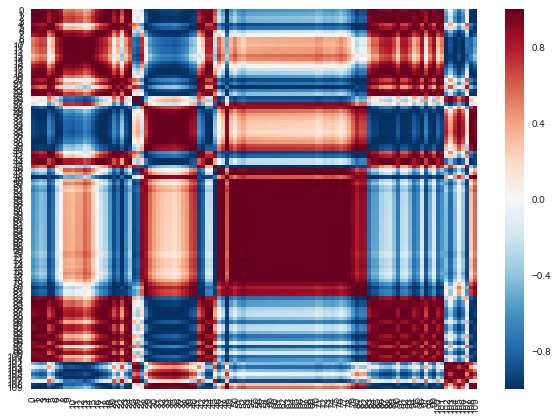

In [1257]:
sns.heatmap(grad_cos)

In [1249]:
grad_cos=cosine_similarity(grad1)

In [1215]:
grad1=np.gradient(tmp[5].iloc[:,4:6])[0]

In [1156]:
shots=[findShot(row[1],row[0],20) for row in ball_high.values]

In [1157]:
shots_total=pd.concat(shots)

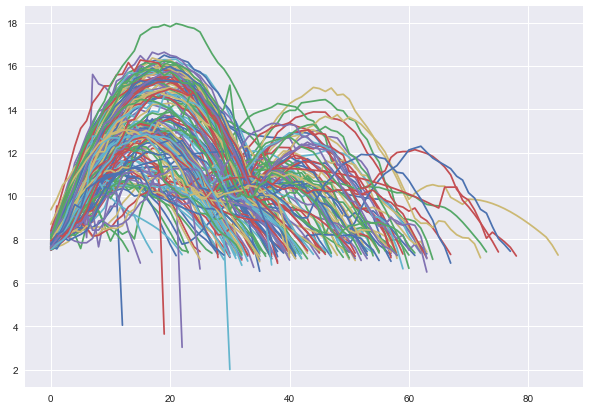

In [631]:
plt.plot(pd.concat(ball_zs,axis=1))